In [14]:
import pandas as pd
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Width of the map used is set to be 1,000 km
width = 1e6

# Determine whether the cyclone move into the big box
map = Basemap(projection='cyl',resolution='c',llcrnrlon=100,\
        llcrnrlat=0,urcrnrlon=180,urcrnrlat=60)

In [3]:
dataset = pd.read_csv('data.csv', low_memory=False) 

# Determine max wind of the each cyclone
max_wind = dataset.groupby('CycNo')['VMAX'].max().rename('VMAX').reset_index()

# Remove cyclones with no vmax data
max_wind = max_wind[max_wind['VMAX']!=0]

# Keep relevant cyclones
dataset = dataset[dataset['CycNo'].isin(max_wind['CycNo'])]

# Provide time details
dataset['TIME'] = pd.to_datetime(dataset['YYYYMMDDHH'], format='%Y%m%d%H')
dataset['MONTH'] = pd.to_numeric(dataset['TIME'].dt.strftime('%m'))
dataset['YEAR'] = pd.to_numeric(dataset['TIME'].dt.strftime('%Y'))
dataset['DAY'] = pd.to_numeric(dataset['TIME'].dt.strftime('%d'))
dataset['HOUR'] = pd.to_numeric(dataset['TIME'].dt.strftime('%H'))

def convert(a):
    """
    Convert longitude and latitude strings to float values

    Parameters
    ----------
    a : string
        String representing longitude and latitude in the dataset
    
    Returns
    -------
    float
        Longitude and latitude float value

    """

    # Break down characters in the string
    A = list(a)

    # For each character
    for i in A:

        # Remove any spacebar
        if i == ' ':
            A.remove(i)
        
        # If North then it is positive, remove letter N
        elif i == 'N':
            A.remove(i)
            
        # If South then it is negative, add negative sign, remove letter S
        elif i == 'S':
            A.remove(i)
            A.insert(0,'-')
        
        # If East then it is positive, remove letter E       
        elif i == 'E':
            A.remove(i)
    
        # If West then it is negative, add negative sign, remove letter W
        elif i == 'W':
            A.remove(i)
            A.insert(0,'-')
        
    # Join all characters together to form a float value        
    return float("".join(A))/10.

dataset['LAT'] = dataset['LatN/S'].apply(convert)
dataset['LON'] = dataset['LonE/W'].apply(convert)

dataset['A_VMAX'] = 0.1884 * dataset['VMAX']**1.288
dataset['VMAX2'] = 0
dataset.loc[dataset['YEAR'] < 1968, 'VMAX2'] = 0.4 * dataset['VMAX'] + 0.6 * dataset['A_VMAX']
dataset.loc[dataset['YEAR'].between(1968,1972), 'VMAX2'] = 0.8 * dataset['VMAX'] + 0.2 * dataset['A_VMAX']
dataset.loc[dataset['YEAR'] > 1972, 'VMAX2'] = dataset['VMAX']

# Keep relevant cyclones
dataset = dataset[dataset['VMAX2'] > 64]

In [4]:
def find_intensification(data):
    extracted_data = data[data.index <= int(data['VMAX'].idxmax())]
    return pd.Series({'LON':extracted_data['LON'].values,'LAT':extracted_data['LAT'].values})

In [5]:
intensification_result = dataset.groupby('CycNo').apply(find_intensification).reset_index()

In [7]:
latitude = np.concatenate(intensification_result['LAT'].values)
longitude = np.concatenate(intensification_result['LON'].values)

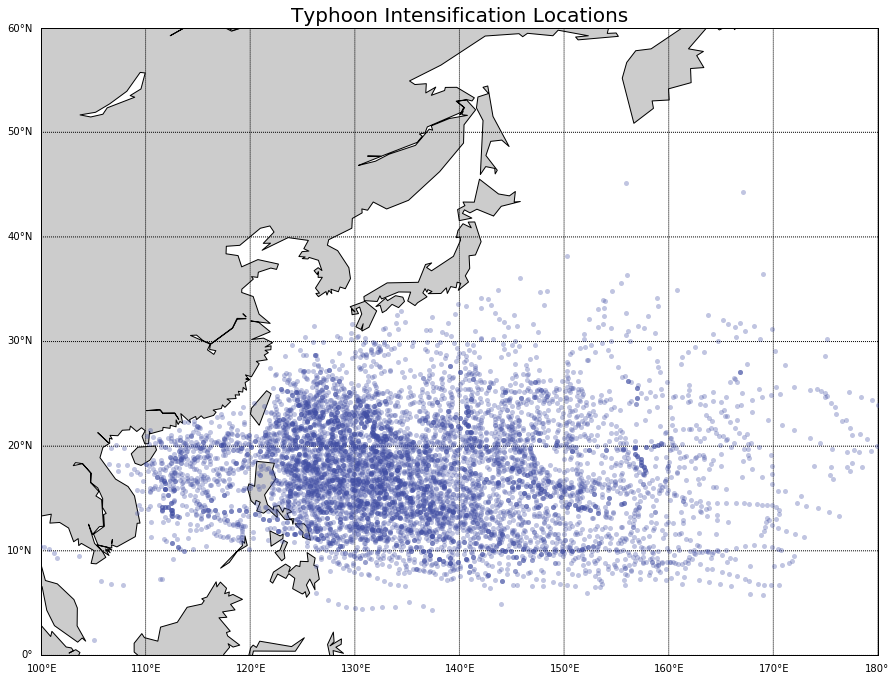

In [29]:
lon_bins = np.arange(100,181,5)
lat_bins = np.arange(0,61,5)
    
density, _, _ = np.histogram2d(latitude,longitude, [lat_bins, lon_bins])

lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the bin mesh to map coordinates:
xs, ys = map(lon_bins_2d, lat_bins_2d)

# define custom colormap
cdict = {'red':  ( (0.0,  1.0,  1.0),
                   (1.0,  0.9,  1.0) ),
         'green':( (0.0,  1.0,  1.0),
                   (1.0,  0.03, 0.0) ),
         'blue': ( (0.0,  1.0,  1.0),
                   (1.0,  0.16, 0.0) ) }

custom_map = LinearSegmentedColormap('custom_map', cdict)
plt.register_cmap(cmap=custom_map)

# add histogram squares and a corresponding colorbar to the map:
# plt.pcolormesh(xs, ys, density,cmap='custom_map')

# cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
# cbar.set_label('Number of earthquakes',size=18)


# translucent blue scatter plot of epicenters above histogram:    
x,y = map(longitude,latitude)
map.plot(x, y, 'o', markersize=5,zorder=6, markerfacecolor='#424FA4',markeredgecolor="none", alpha=0.33)

    
# make image bigger:
plt.title('Typhoon Intensification Locations', fontsize=20)
plt.gcf().set_size_inches(15,15)
map.drawcoastlines()
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])

plt.show()

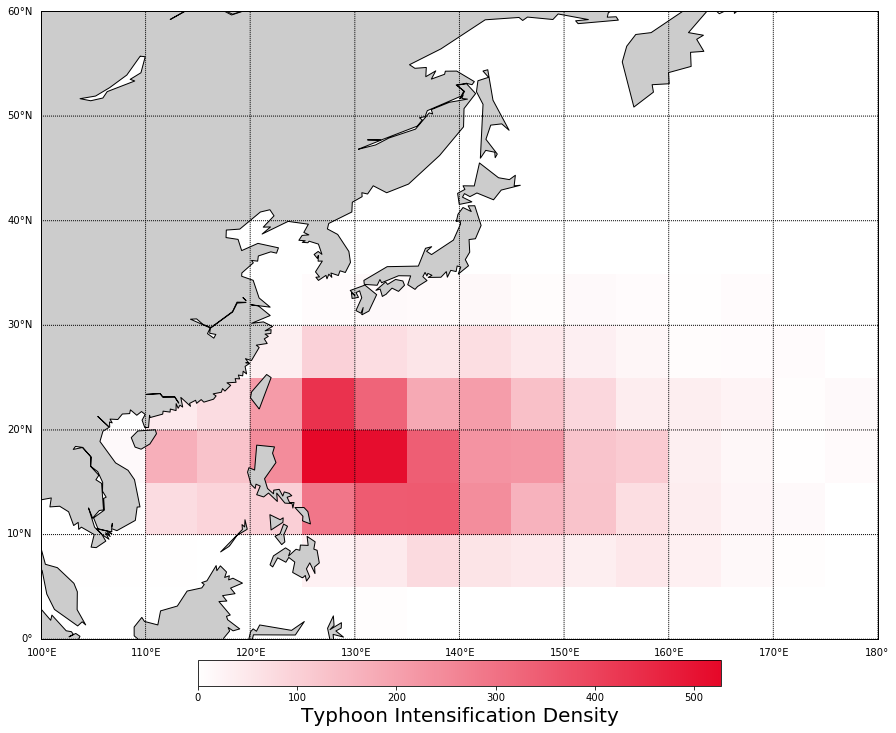

In [33]:
lon_bins = np.arange(100,181,5)
lat_bins = np.arange(0,61,5)
    
density, _, _ = np.histogram2d(latitude,longitude, [lat_bins, lon_bins])

lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the bin mesh to map coordinates:
xs, ys = map(lon_bins_2d, lat_bins_2d)

# define custom colormap
cdict = {'red':  ( (0.0,  1.0,  1.0),
                   (1.0,  0.9,  1.0) ),
         'green':( (0.0,  1.0,  1.0),
                   (1.0,  0.03, 0.0) ),
         'blue': ( (0.0,  1.0,  1.0),
                   (1.0,  0.16, 0.0) ) }

custom_map = LinearSegmentedColormap('custom_map', cdict)
plt.register_cmap(cmap=custom_map)

# add histogram squares and a corresponding colorbar to the map:
plt.pcolormesh(xs, ys, density,cmap='custom_map')

cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
cbar.set_label('Typhoon Intensification Density',size=20)


# translucent blue scatter plot of epicenters above histogram:    
# x,y = map(longitude,latitude)
# map.plot(x, y, 'o', markersize=5,zorder=6, markerfacecolor='#424FA4',markeredgecolor="none", alpha=0.33)

    
# make image bigger:
# plt.title('Typhoon Intensification Density', fontsize=20)
plt.gcf().set_size_inches(15,15)
map.drawcoastlines()
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])

plt.show()